# Reading WFS with GeoPandas

A simple example of how to query WMS/WFS capability and features and download WFS data from GeoServer.

<a id="top"></a>
# Table of contents
* [General WMS/WFS service capability and features](#a649e1d8-ce92-4eb8-b284-27d6707dc2b4)
* [Recent water samples in WFS](#2718d8d9-8729-4eda-a9fc-6dac02f34bd8)
* [Map fetching using WMS](#c7bc8d45-fff8-4deb-8e45-4f7456f91ace)

In [7]:
WFS_URL = "https://geoserver.sg-dev.easi-eo.solutions/geoserver/unhas/ows?service=WFS"
WFS_LAYER = "unhas:Water_Sample_Coordinates"

WMS_URL = "https://geoserver.sg-dev.easi-eo.solutions/geoserver/unhas/wms?service=WMS"
WMS_LAYER = "Water_Sample_Coordinates"

## <span id="a649e1d8-ce92-4eb8-b284-27d6707dc2b4">General WMS/WFS service capability and features [&#9652;](#top)</span>
Using `owslib`. See https://geopython.github.io/OWSLib/usage.html#wms

In [8]:
from owslib.wfs import WebFeatureService

wfs = WebFeatureService(url=WFS_URL)

print(f"Service provider: {wfs.identification.title}")
print(f"WFS version: {wfs.version}")
print(f"Available operations: {[operation.name for operation in wfs.operations]}")
print(f"Available data layers: {list(wfs.contents)}")

# Uncomment the following lines to print all metadata of all layers
# for layer, meta in wfs.items():
#     print(f"\n{layer}: {meta.__dict__}")

Service provider: None
WFS version: 1.0.0
Available operations: ['GetCapabilities', 'DescribeFeatureType', 'GetFeature', 'Transaction', 'LockFeature', 'GetFeatureWithLock']
Available data layers: ['unhas:Boundary_CA_TempeLake_AR', 'unhas:Boundary_administration', 'unhas:Flood_2019', 'unhas:Flood_2020', 'unhas:Flood_2021', 'unhas:Forest_Function', 'unhas:Geology', 'unhas:LandCapability', 'unhas:Land_System', 'unhas:Rainfall', 'unhas:Rainfall_gauge', 'unhas:Slope', 'unhas:Soil', 'unhas:Water_Sample_Coordinates', 'unhas:linement']


## <span id="2718d8d9-8729-4eda-a9fc-6dac02f34bd8">Recent water samples in WFS [&#9652;](#top)</span>
Using `requests` and `Geopandas`. Based on https://gis.stackexchange.com/a/302346

unhas:Water_Sample_Coordinates data is of shape (24, 13)


,id,TITIK,X,Y,Lbr_Sungai,Ket_Citra,DESA,KECAMATAN,KABUPATEN,PROVINSI,TIM_SURV,TSS__mg_L_,geometry
0,Water_Sample_Coordinates.1,3,119.983734,-4.192309,16,Citra Sentinel 2,UGI,SABBANGPARU,WAJO,SULAWESI SELATAN,Tim 2,34.155715,POINT Z (119.98370 -4.19230 0.00000)
1,Water_Sample_Coordinates.2,15,120.018318,-4.077734,6,Citra Sentinel 2,UJUNGE,TANASITOLO,WAJO,SULAWESI SELATAN,Tim 3,150.025099,POINT Z (120.01830 -4.07770 0.00000)
2,Water_Sample_Coordinates.3,16,120.022983,-4.129490,60,Citra Landsat 8,WATALIPUE,TEMPE,WAJO,SULAWESI SELATAN,Tim 3,64.242424,POINT Z (120.02300 -4.12950 0.00000)
3,Water_Sample_Coordinates.4,12,119.859901,-4.099675,11,Citra Sentinel 2,BAPANGI,PANCALAUTANG,SIDENRENGRAPPANG,SULAWESI SELATAN,Tim 1,0.000000,POINT Z (119.85990 -4.09970 0.00000)
4,Water_Sample_Coordinates.5,7,119.926974,-4.196781,15,Citra Sentinel 2,KESSING,DONRI-DONRI,SOPPENG,SULAWESI SELATAN,Tim 2,53.809524,POINT Z (119.92700 -4.19680 0.00000)


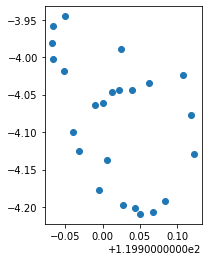

In [9]:
from requests import Request
import geopandas as gpd

# Parameters for fetching the data
params = dict(
    service='WFS', 
    version="1.1.1", 
    request='GetFeature',
    typeName=WFS_LAYER,
    outputFormat='json'
)
# Parse the URL with parameters
q = Request('GET', WFS_URL, params=params).prepare().url

# Read data from URL
data = gpd.read_file(q)
print(f"{WFS_LAYER} data is of shape {data.shape}")
display(data.head())
data.plot();

## <span id="c7bc8d45-fff8-4deb-8e45-4f7456f91ace">Map fetching using WMS [&#9652;](#top)</span>
Probably not so useful for data analysis

In [10]:
import io
from owslib.wms import WebMapService
import cartopy
import matplotlib.pyplot as plt

wms = WebMapService(url=WMS_URL)

print(f"Service provider: {wms.identification.title}")
print(f"WMS version: {wms.version}")
print(f"Available operations: {[operation.name for operation in wms.operations]}")
print(f"Available data layers: {list(wms.contents)}")

Service provider: None
WMS version: 1.1.1
Available operations: ['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'DescribeLayer', 'GetLegendGraphic', 'GetStyles']
Available data layers: ['Boundary_CA_TempeLake_AR', 'Boundary_administration', 'Flood_2019', 'Flood_2020', 'Flood_2021', 'Forest_Function', 'Geology', 'LandCapability', 'Land_System', 'Rainfall', 'Rainfall_gauge', 'Slope', 'Soil', 'Wajo_City_4', 'Water_Sample_Coordinates', 'linement']


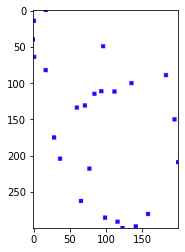

In [11]:
bbox = wms[WMS_LAYER].boundingBoxWGS84
response = wms.getmap(   
    layers=[WMS_LAYER],
    styles=list(wms[WMS_LAYER].styles),
    srs='EPSG:4326',
    bbox=bbox,
    size=(200, 300),
    format='image/png',
    transparent=True
)
image = io.BytesIO(response.read())
data = plt.imread(image)
plt.imshow(data);

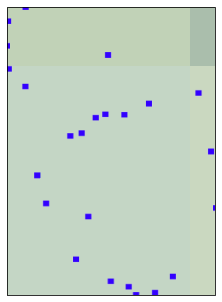

In [12]:
extent = (bbox[0], bbox[2], bbox[1], bbox[3])
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.PlateCarree())
ax.stock_img()
ax.imshow(data, origin="upper", extent=extent, transform=cartopy.crs.PlateCarree())
plt.show()